# Confusion, by the Numbers
2018-11-23

by Kathleen Esfahany

In [1]:
import numpy as np
import csv

In [2]:
csv_data = np.asarray(list(csv.reader(open("./senioryeardata.csv", "r"))))

# categories
print ("Categories: " + str(csv_data[0]))

# example data
print ("Example data: " + str(csv_data[1]))

Categories: ['Span' 'Duration' 'User' '# Revisions']
Example data: ['Wed, 11/8/2017, 6:38:50 AM - 6:53:56 AM' '00:15:05s' 'Kathleen Esfahany'
 '538']


### Format the data
Here I make a new array called `sy_data` (sy being "senior year"). 

I discard irrelevant data (such as User) and reformat other metrics (split span into groups, convert time to military, convert revisions from strings to integers).


In [3]:
# new categories
sy_data_categories = ["DayName", "Date", "Time Start", "Time Finish", "Duration", "Revisions"]

In [4]:
# function time_convert(time_raw)
#
# parameter `time_raw` is a string fomatted as "HH:MM:SS XM - HH:MM:SS XM"
#
# returns a list with two values: the start time and finish time in military format, "HH:MM:SS"

def time_convert(time_raw):
    
    return_value = []
    
    # step 1: split into start and end
    time_split = time_raw.split(" - ") # dash with space sandwich

    # step 2: convert to military time
    for i in range(len(time_split)):
        time_value, am_pm = time_split[i].split()

        # if 12PM, don't change it
        if (time_value[0:2] == "12") and (am_pm == 'PM'):
            pass
            
        # if 12AM, convert 12 to 0
        elif (time_value[0:2] == "12") and (am_pm == 'AM'):
            time_value = str(0) + time_value[2:]

        # if PM, then add 12 to hour value
        elif am_pm == 'PM':
            new_hour = int(time_value.split(":")[0])+12
            time_value = str(new_hour) + time_value[(len(str(new_hour-12))):]
        
        return_value.append(time_value)
    
    return return_value # two-value list of the start and finish times

In [5]:
# initalize list of lists
sy_data = [[] for x in range(len(csv_data)-1)]

# fill in data
for i in range(len(csv_data)-1):
    
    # add data and time 
    span_raw = csv_data[i+1,0].split(", ") # comma with a space
    sy_data[i] += span_raw[0:2] + time_convert(span_raw[2])
    
    # add duration
    sy_data[i] += [csv_data[i+1,1][:-1]]
    
    # add revision count
    sy_data[i] += [int(csv_data[i+1,3])]

sy_data = np.asarray(sy_data)

In [6]:
print("Example of New Data:")
sy_data[:5]

Example of New Data:


array([['Wed', '11/8/2017', '6:38:50', '6:53:56', '00:15:05', '538'],
       ['Wed', '11/8/2017', '7:16:39', '7:20:52', '00:04:12', '27'],
       ['Wed', '11/8/2017', '7:50:29', '7:50:56', '00:00:27', '33'],
       ['Wed', '11/8/2017', '8:24:35', '8:25:36', '00:01:01', '21'],
       ['Wed', '11/8/2017', '10:14:46', '10:21:16', '00:06:30', '10']],
      dtype='<U10')

### Analysis

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42 # settings to make figure text editable in Adobe Illustrator
plt.rcParams['ps.fonttype'] = 42

In [8]:
# useful constants
ordered_days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'] # days of the week
ind = np.arange(7) # array with seven spots, useful for bar graphs
first_day_value = ordered_days.index(sy_data[0][0]) # mod 7 value (based on week structure) of the first date

# list of unique dates
## note: I am not using np.unique() because it doesn't maintain order
sy_data_monoday = []
for i in range(len(sy_data)):
    if sy_data[i][1] not in sy_data_monoday:
        sy_data_monoday.append(sy_data[i][1])

# hand-picked depressing colors
colors = ["#B8702D","#785D8D","#273549","#90605B","#6D7B8D","#A24C34","#5B5957"]

In [9]:
# number of days I made edits for each of the seven day categories
day_count = []
for i in range(len(ordered_days)): # get a count for each of seven days
    total = 0
    for j in range(len(sy_data_monoday)): # check week day for each unique date
        if (sy_data[list(sy_data[:,1]).index(sy_data_monoday[j])][0] == ordered_days[i]):
            total += 1
    day_count.append(total)

In [10]:
for i in range(len(day_count)): # number of Sun's, Mon's, Tue's, etc
    print (ordered_days[i] + ": " + str(day_count[i]))

assert (len(sy_data_monoday) == np.sum(day_count))
print("Total Days Editing: " + str(np.sum(day_count)))


Sun: 14
Mon: 26
Tue: 23
Wed: 25
Thu: 24
Fri: 20
Sat: 9
Total Days Editing: 141


In [11]:
import pandas as pd


In [12]:
# step 1: get total revisions for each unique date

revisions = []
for i in range(len(sy_data_monoday)):
    total = 0
    for j in range(len(sy_data)):
        if sy_data[j][1] == sy_data_monoday[i]:
            total += int(sy_data[j][-1])
    revisions.append(total)


In [13]:
# step 2: fill in missing dates

# range of dates from first edit to the last
idx = pd.date_range(sy_data_monoday[0],sy_data_monoday[-1])

# series of sy dates w/ their revision counts
sydates = pd.Series(revisions, sy_data_monoday)

# convert index to a DatetimeIndex
sydates.index = pd.DatetimeIndex(sydates.index)

# reindex to fill in missing dates with an automatic revision count of zero
sydates = sydates.reindex(idx, fill_value = 0)


In [14]:
# step 3: extract as arrays
revisions = sydates.values
dates_full = (sydates.index).strftime("%-m/%-d/%Y")

### Figure 1. Revisions per Day of Week

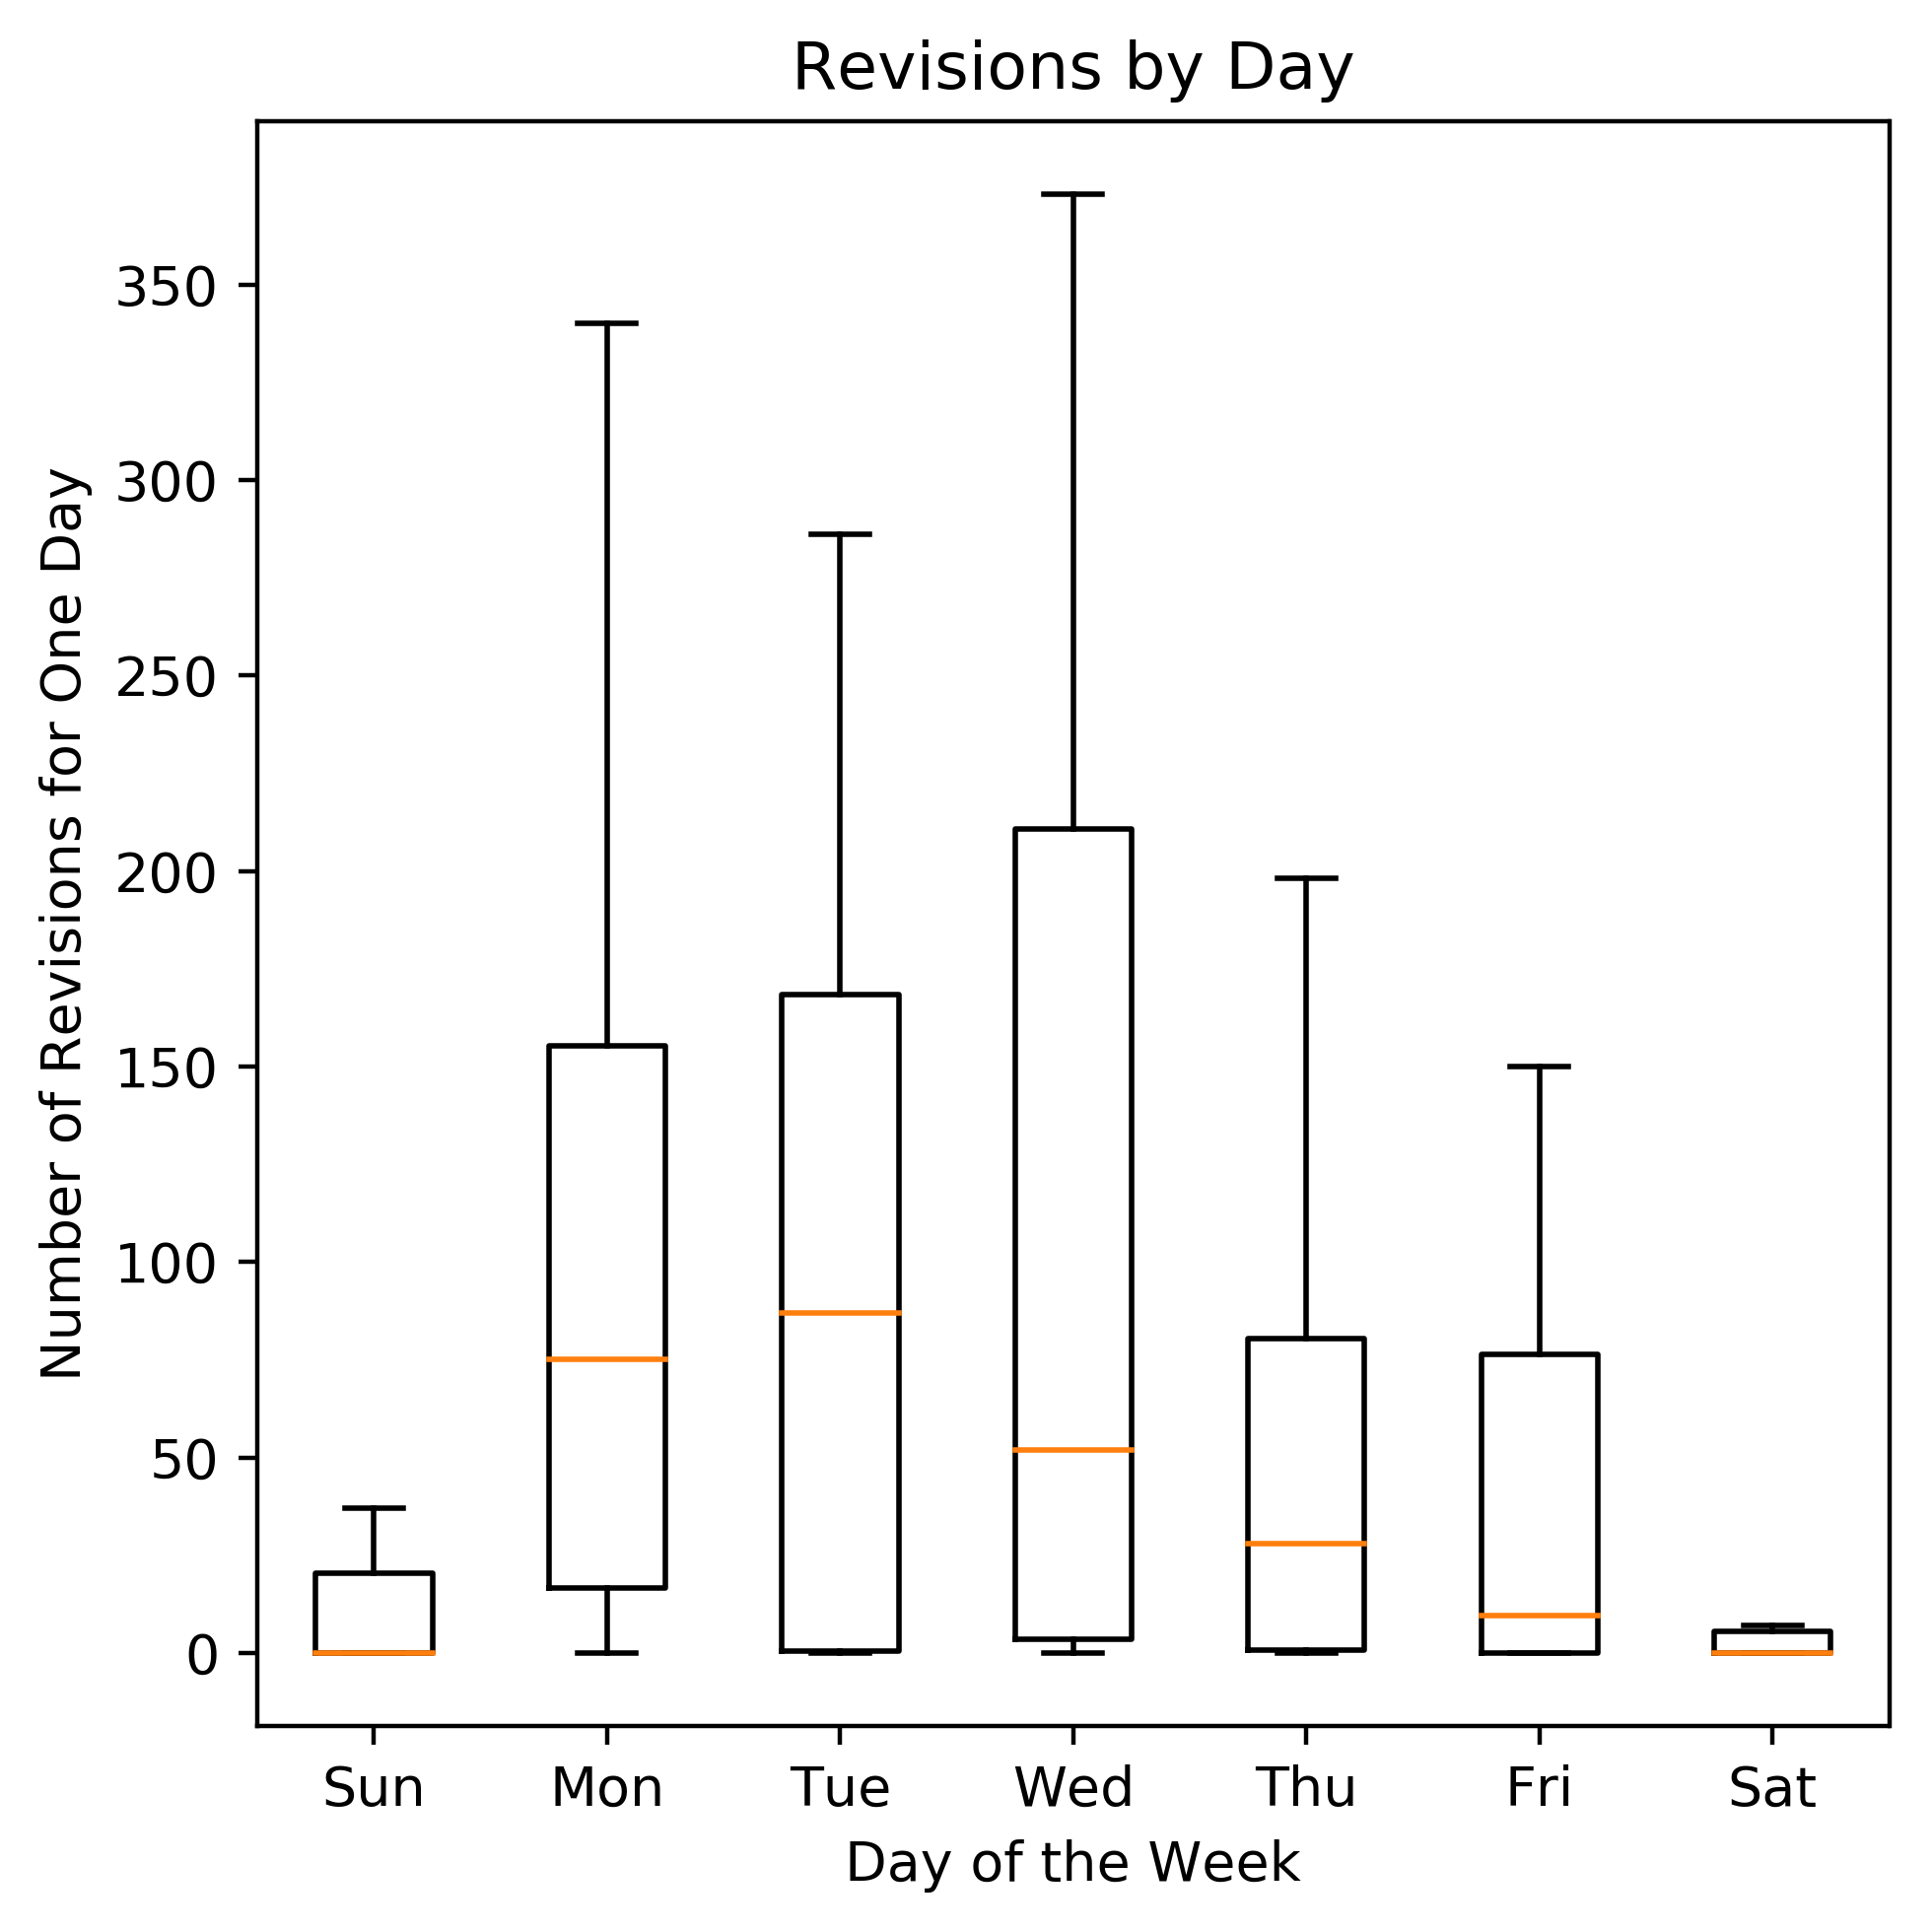

In [15]:
# Boxplot: Revisions by Day of Week

plt.figure(figsize=(5,5), dpi=400)

day_value = first_day_value
revision_dist = [[] for x in ind]

for i in range(len(revisions)):
    revision_dist[ind[day_value]].append(revisions[i])
    day_value = (day_value + 1)%7

plt.boxplot(revision_dist, showfliers = False)
plt.xticks(ind+1, ordered_days)
plt.title("Revisions by Day")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Revisions for One Day")
plt.tight_layout()
plt.savefig("./figs/boxplot.pdf")
plt.show()

### Figure 3. Revisions for One Year

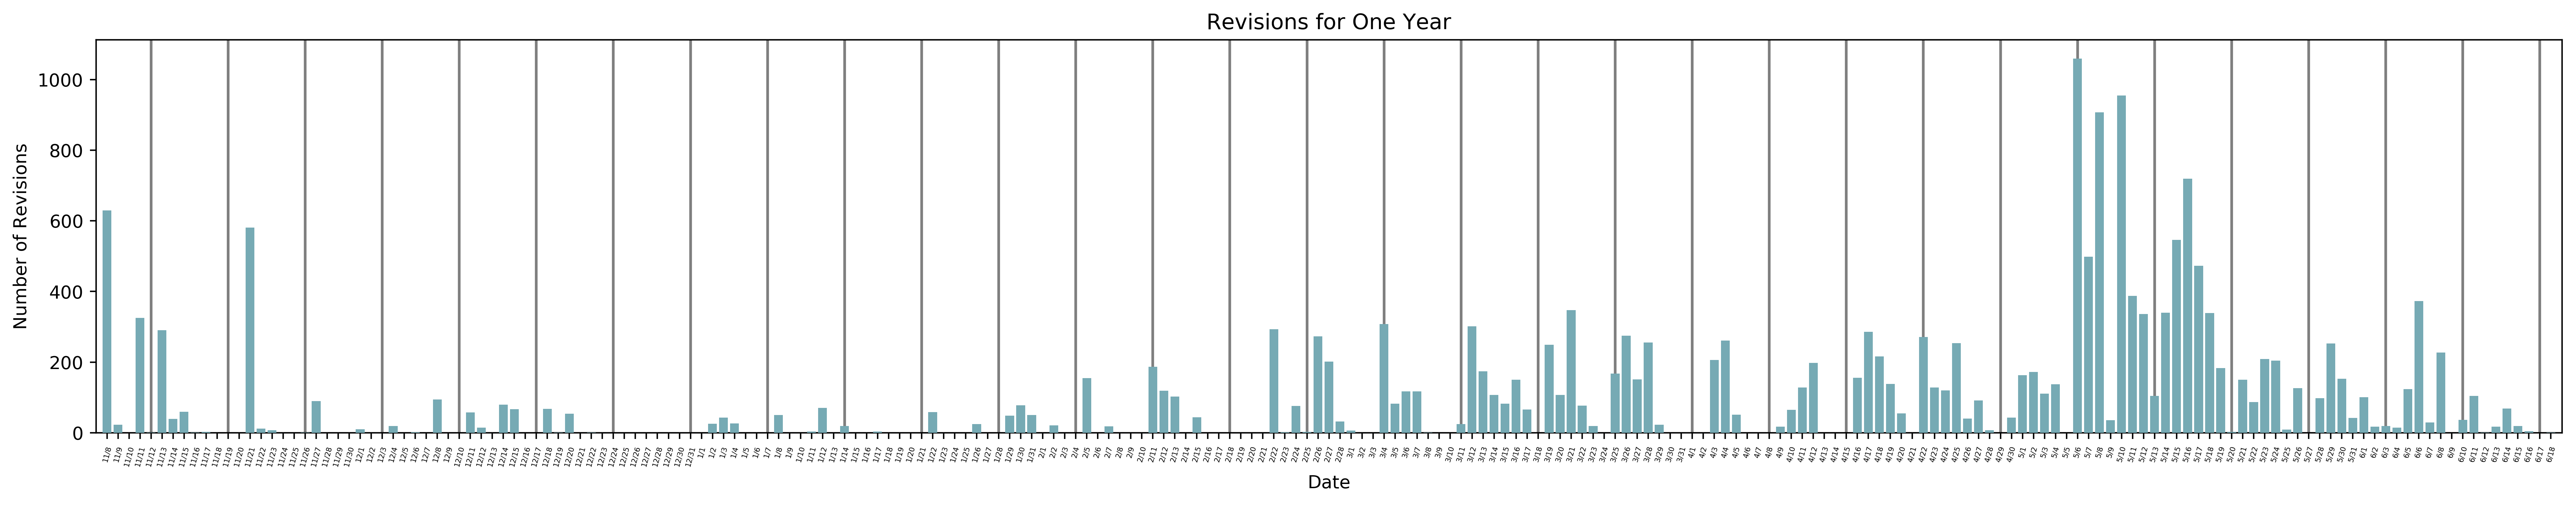

In [16]:
# Bar Chart: Total Revisions Per Each Date
plt.figure(figsize=(20,4), dpi = 400)
ind_long = np.arange(len(dates_full)) # index accounting for all dates
ticks = [dates_full[x][:-5] for x in range(len(dates_full))] # ticks without the year

# set day_value to the first day
day_value = first_day_value

# plot
for i in range(len(dates_full)):
    if day_value == 0:
        plt.axvline(ind_long[i], color = "k", alpha = 0.5)
    day_value = (day_value+1)%7
for i in range(len(dates_full)):
    if (revisions[i] > 0):
        day = sy_data[:,0][list(sy_data[:,1]).index(dates_full[i])]
        plt.bar(ind_long[i],revisions[i], color = '#76AAB4',zorder = 100)
plt.xticks(ind_long, ticks, rotation=75, size = 4)
plt.title("Revisions for One Year")
plt.xlabel("Date")
plt.xlim(-1, ind_long[-1] + 1)
plt.ylabel("Number of Revisions")
plt.tight_layout()
plt.savefig("./figs/oneyear.pdf")
plt.show()

### 4. Revisions by Hour

In [17]:
# parameter time_raw is HH:MM:SS
def time_to_float(time_raw):
    hours, minutes, seconds = time_raw.split(":")
    return float(hours + str(int(minutes)/60)[1:4] + str(int(seconds)/60)[2:4])

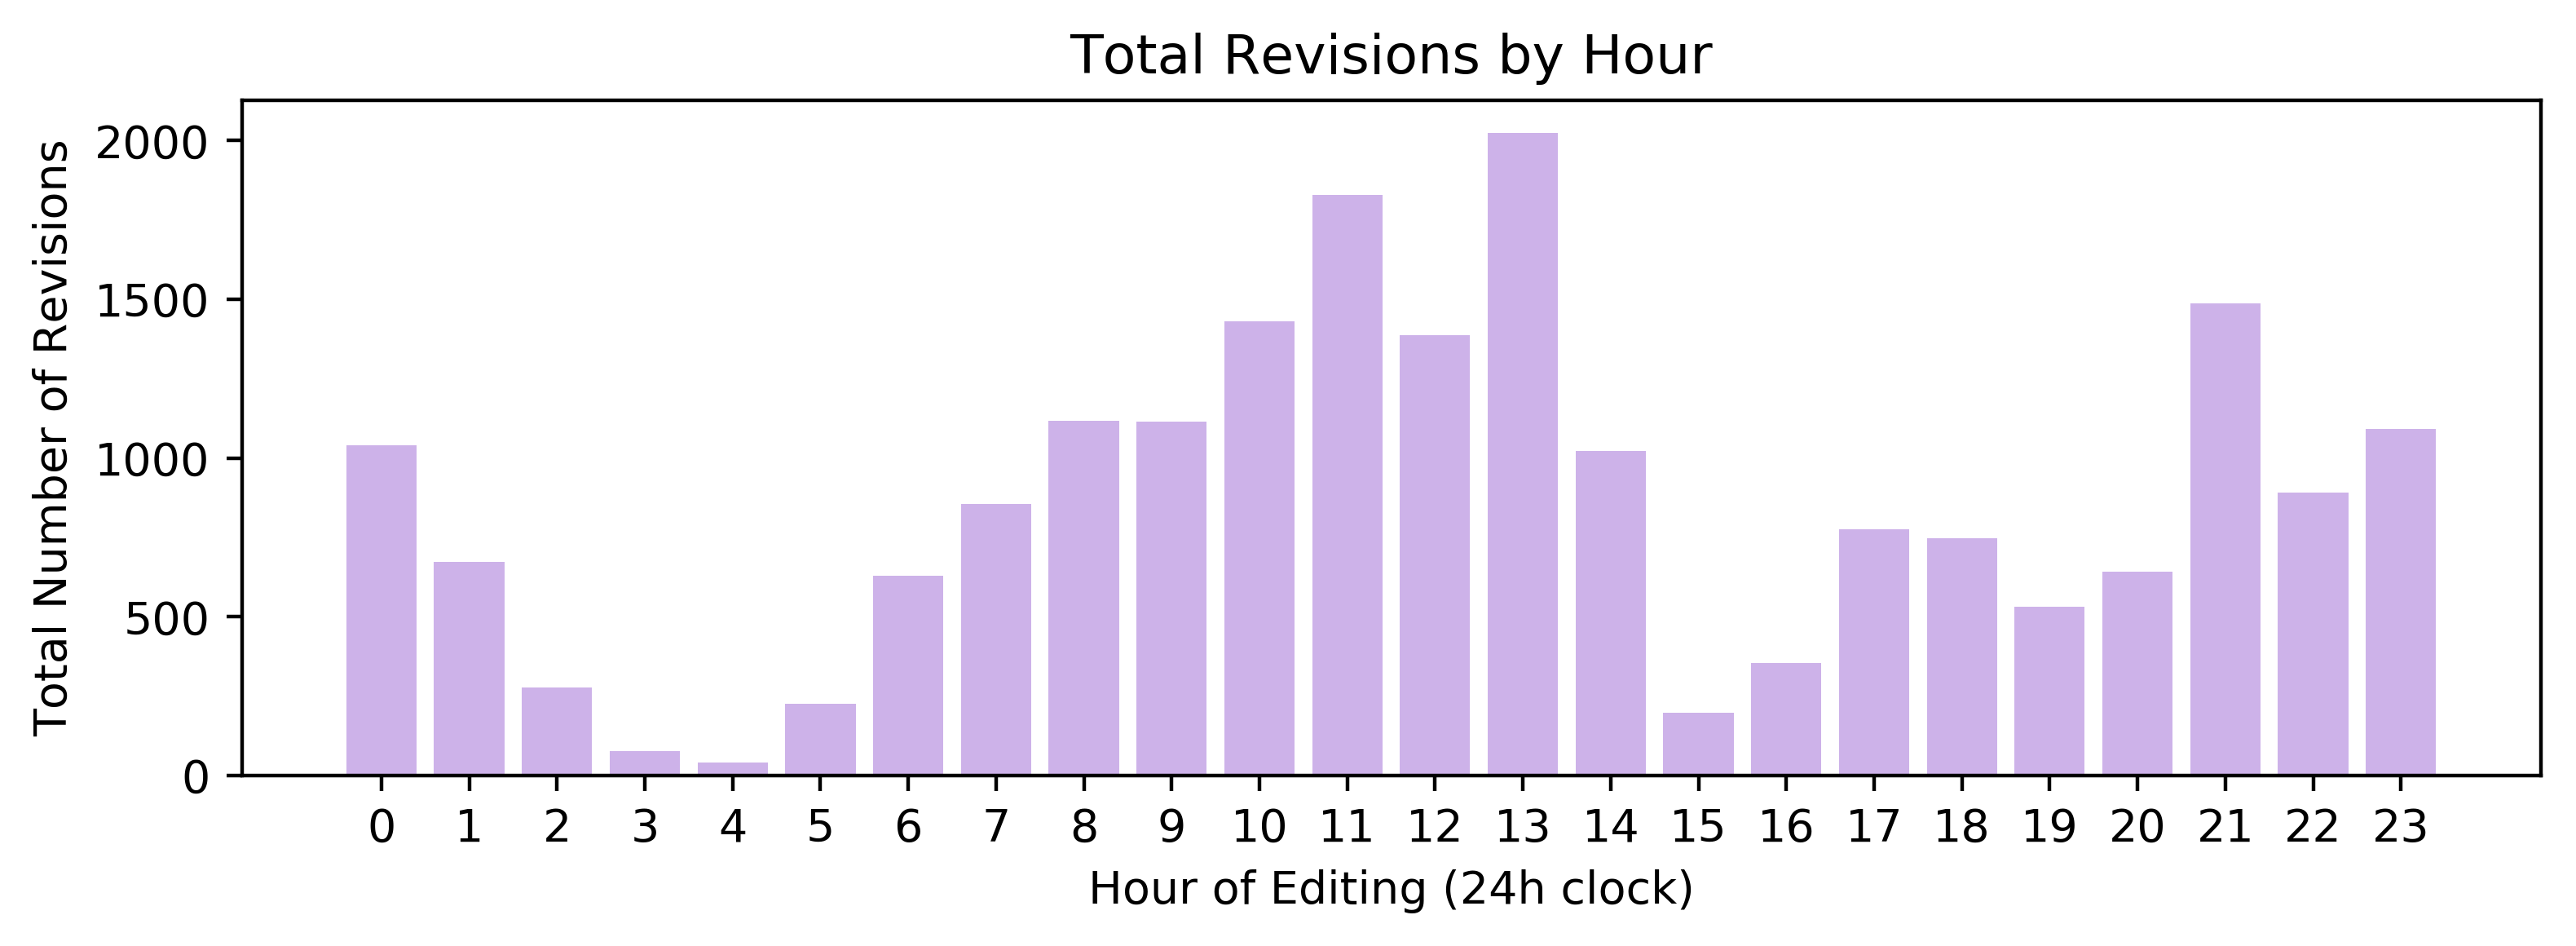

In [18]:
# bar chart with total number of revisions per hour

plt.figure(figsize=(8,3), dpi=400)


revision_dist = [0 for i in range(24)]
for i in range(24): # check every hour
    for j in range(len(sy_data)):
        if (str(time_to_float(sy_data[j][2])).split(".")[0]) == str(i):
            revision_dist[i] += int(sy_data[j][-1])

plt.bar(np.arange(24),revision_dist, color = "#CDB2E9")
plt.xticks(np.arange(24), np.arange(24).astype(str))
plt.title("Total Revisions by Hour of Day")
plt.xlabel("Hour of Editing (24h clock)")
plt.ylabel("Total Number of Revisions")
plt.title("Total Revisions by Hour")
plt.tight_layout()
plt.savefig("./figs/hours.pdf")
plt.show()

### Figure 6. Hourly Activity by Day

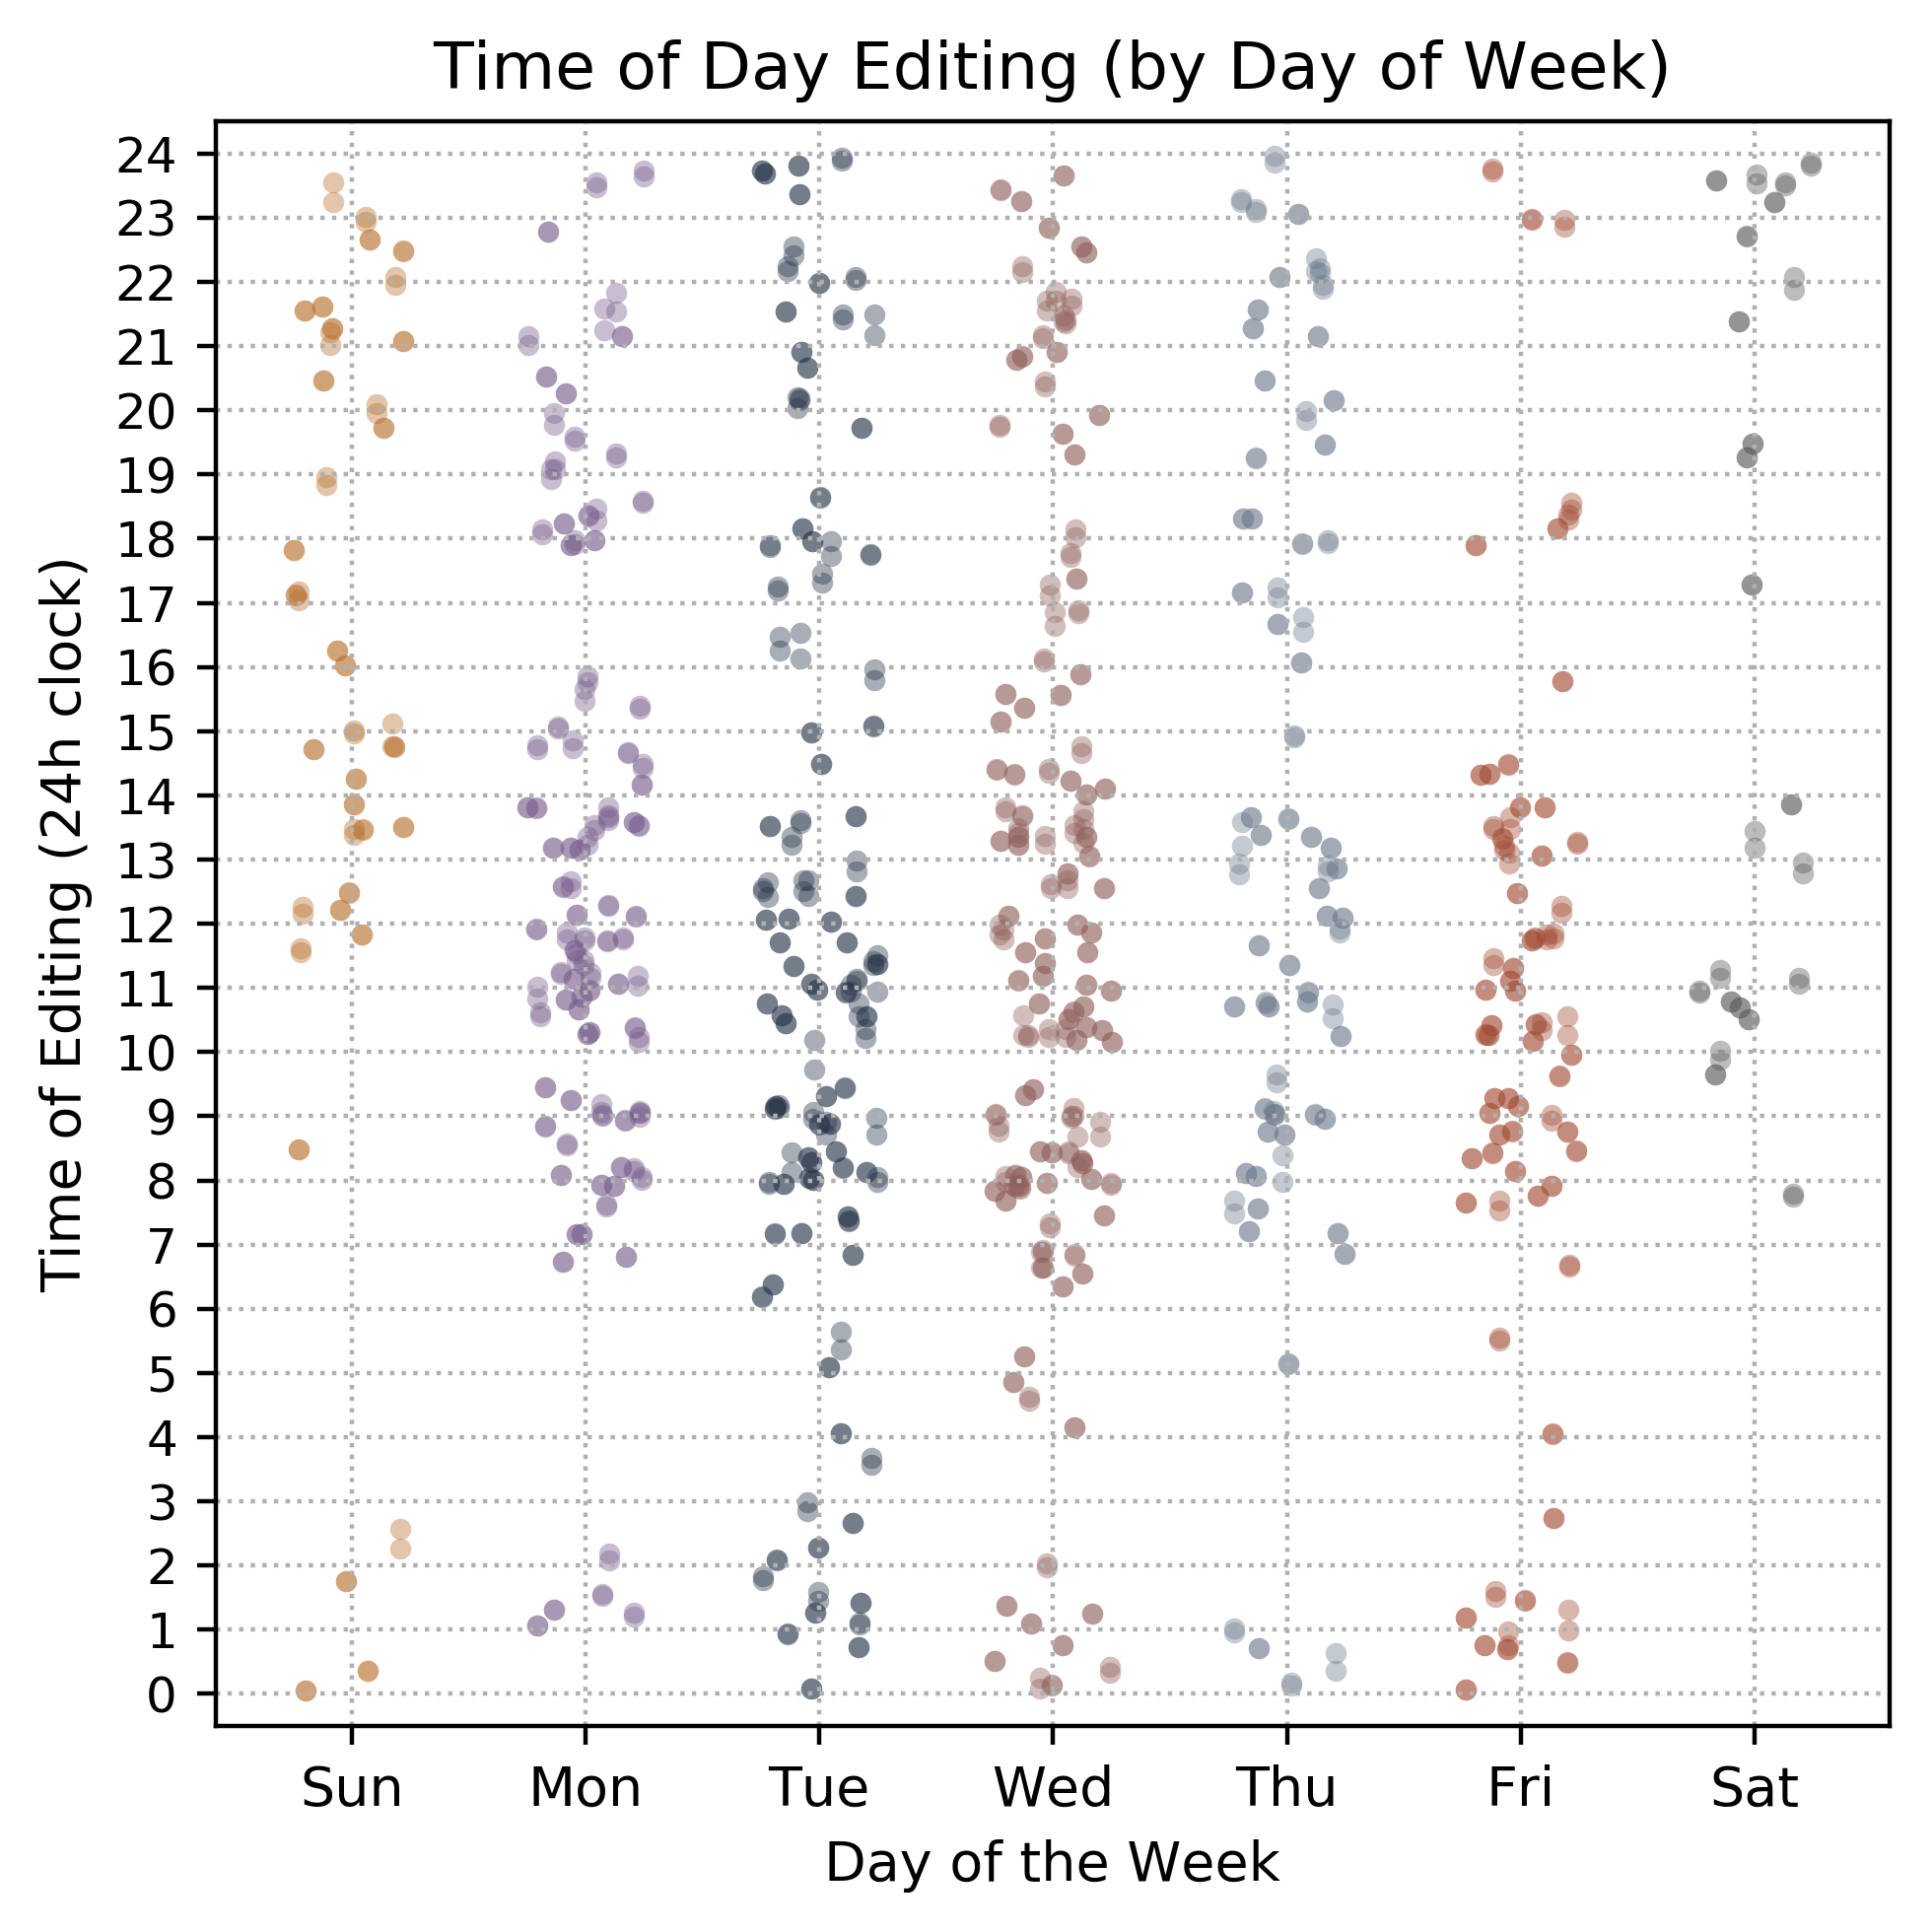

In [19]:
plt.figure(figsize=(5,5), dpi=400)

for i in range(len(sy_data)):
    day_value = ordered_days.index(sy_data[i][0]) 
    x = np.asarray([day_value for x in range(2)])-0.25+(np.random.rand())/2
    y = [time_to_float(sy_data[i][2]),time_to_float(sy_data[i][3])]

    plt.scatter(x,y, s=15, color=colors[day_value], alpha = 0.4, linewidths= 0)

plt.xticks(ind, ordered_days)
plt.yticks(np.arange(25),np.arange(25).astype(str), size=9)
plt.title("Time of Day Editing (by Day of Week)")
plt.xlabel("Day of the Week")
plt.ylabel("Time of Editing (24h clock)")
plt.grid(linestyle = "dotted")
plt.ylim(-0.5,24.5)

plt.tight_layout()
plt.savefig("./figs/hourly_daily.pdf")
plt.show()